In [41]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

In [29]:
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

In [30]:
Train_path = "stage1_train/"
Test_path = "stage1_test/"

In [31]:
Train_ids = next(os.walk(Train_path))[1]
Test_ids = next(os.walk(Test_path))[1]

In [32]:
img_width = 128 
img_height = 128
img_channels = 3

In [37]:
X_train = np.zeros((len(Train_ids),img_height, img_width, img_channels), dtype= np.uint8)
y_train = np.zeros((len(Train_ids),img_height, img_width,1), dtype = bool)

In [38]:
for  n, id_ in tqdm(enumerate(Train_ids), total = len(Train_ids)):
    path = Train_path + id_
    img = imread(path + '/images/'+ id_ + '.png')[:,:,:img_channels]
    img = resize(img, (img_height, img_width), mode = 'constant', preserve_range =True)
    X_train[n] = img
    mask = np.zeros((img_height, img_width, 1), dtype = bool)
    for mask_file in next(os.walk(path+'/masks/'))[2]:
        mask_ = imread(path +'/masks/'+mask_file)
        mask_ = np.expand_dims(resize(mask_,(img_height, img_width), mode = 'constant', preserve_range= True), axis =-1)
        mask = np.maximum(mask, mask_)

    y_train[n] = mask
    #  y_train = np.zeros((len(Train_ids), img_height, img_width, 1), dtype=bool)

100%|██████████| 670/670 [08:24<00:00,  1.33it/s]


In [40]:
X_test = np.zeros((len(Test_ids), img_width,img_height, img_channels), dtype= np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(Test_ids), total = len(Test_ids)):
    path = Test_path + id_
    img = imread(path + '/images/'+ id_ + '.png')[:,:,:img_channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 65/65 [00:02<00:00, 29.07it/s]

Done!


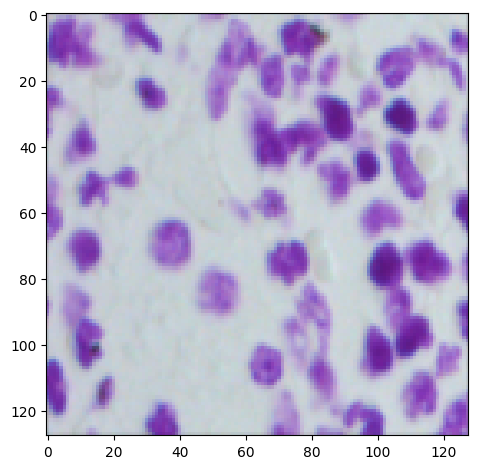

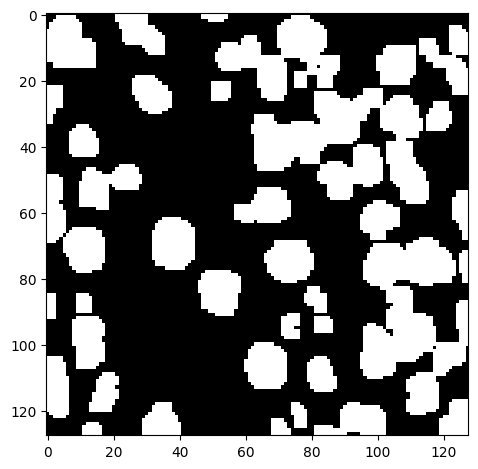

In [44]:
import random
image_x = random.randint(0,len(Train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x ]))
plt.show()

In [50]:
np.random.seed = 42

In [45]:
# model = tf.keras.model.Sequential([
#         tf.keras.layers.Input(shape=(img_width, img_height, img_channels))
        
# ])
inputs = tf.keras.layers.Input(shape=(img_width, img_height, img_channels))

s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)
c1 = tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPool2D(2,2)(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPool2D(2,2)(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPool2D(2,2)(c4)


c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)
p5 = tf.keras.layers.MaxPool2D(2,2)(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding= 'same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding= 'same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding= 'same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(c9)


In [46]:
model  = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [49]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.keras', verbose =1, save_best_only=True)
callbacks =[
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir ='logs')
]

In [56]:
results  = model.fit(X_train,y_train, validation_split=0.1, batch_size = 16, epochs=25, callbacks= callbacks)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 273ms/step - accuracy: 0.9579 - loss: 0.1099 - val_accuracy: 0.9569 - val_loss: 0.1178
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.9588 - loss: 0.1083 - val_accuracy: 0.9609 - val_loss: 0.1066
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.9616 - loss: 0.1011 - val_accuracy: 0.9639 - val_loss: 0.0936
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 464ms/step - accuracy: 0.9605 - loss: 0.1058 - val_accuracy: 0.9615 - val_loss: 0.1014
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - accuracy: 0.9635 - loss: 0.0950 - val_accuracy: 0.9646 - val_loss: 0.0956


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step 


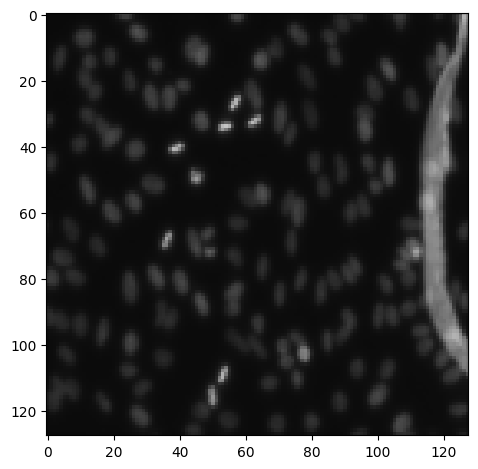

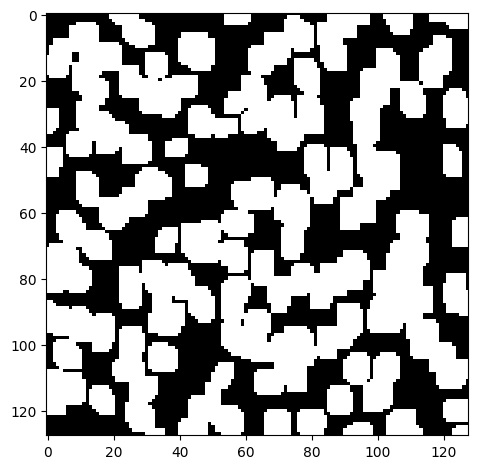

C:\Users\lehar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


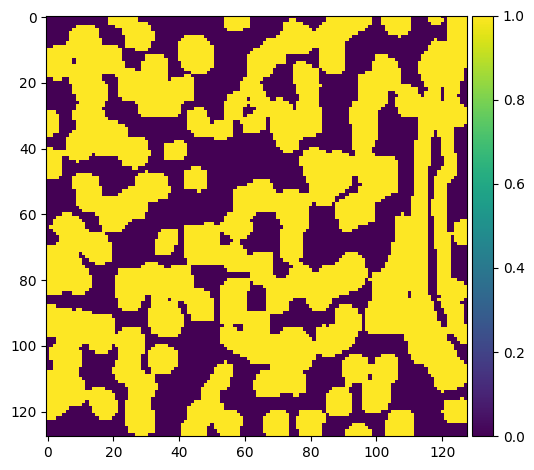

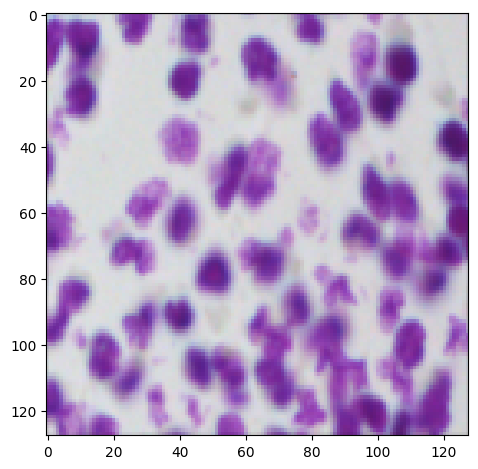

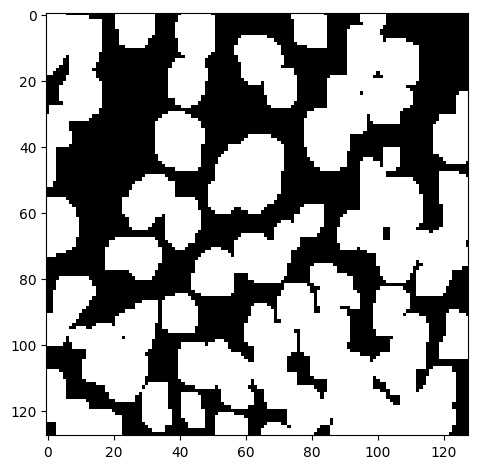

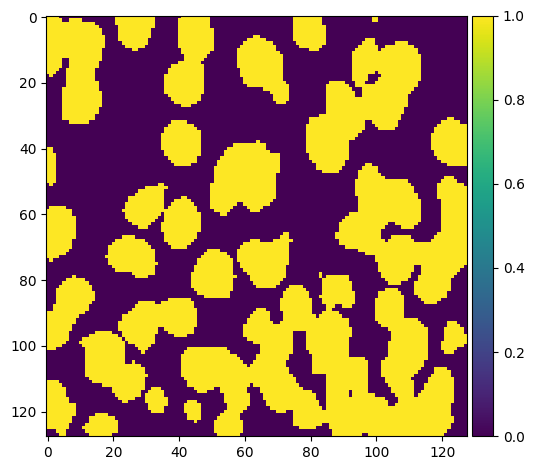

In [57]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose =1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

ix = random.randint(0, len(preds_test_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [55]:
!tensorboard --logdir=logs/ --host localhost --port 8000

^C
